In [278]:
import kagglehub
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.cm import rainbow
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
#pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit 

## Step 1: Download the Heart Failure Prediction Dataset


In [279]:
import os
import zipfile
# Download the dataset
path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")

# Check if the dataset is a ZIP file
if path.endswith('.zip'):
    # Extract the ZIP file
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall("extracted_dataset")
    
    # Find the CSV file in the extracted folder
    extracted_folder = "extracted_dataset"
    csv_file = [f for f in os.listdir(extracted_folder) if f.endswith('.csv')][0]
    csv_file_path = os.path.join(extracted_folder, csv_file)
else:
    # If it's not a ZIP file, look for the CSV file directly
    csv_file = [f for f in os.listdir(path) if f.endswith('.csv')][0]
    csv_file_path = os.path.join(path, csv_file)

# Load the dataset with pandas
dataset = pd.read_csv(csv_file_path)

# Display the dataset
dataset

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


## Step 2: Dataset Preparation

In [280]:
#Setting a random seed ensures that any random processes produce the same results each time the code is run.
import random
random.seed(42)

### Feature Preprocessing

In [281]:
X = dataset.drop(columns="HeartDisease")  # All columns except the target --> feature matrix
y = dataset["HeartDisease"]               # Target column --> target vector

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()   # scale features between 0 and 1 -> (x - min) / (max - min)

# Normalize only numeric columns
for col in X.columns:
    if pd.api.types.is_numeric_dtype(X[col]):
        X[col] = scaler.fit_transform(X[[col]])
X

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,0.244898,M,ATA,0.70,0.479270,0.0,Normal,0.788732,N,0.295455,Up
1,0.428571,F,NAP,0.80,0.298507,0.0,Normal,0.676056,N,0.409091,Flat
2,0.183673,M,ATA,0.65,0.469320,0.0,ST,0.267606,N,0.295455,Up
3,0.408163,F,ASY,0.69,0.354892,0.0,Normal,0.338028,Y,0.465909,Flat
4,0.530612,M,NAP,0.75,0.323383,0.0,Normal,0.436620,N,0.295455,Up
...,...,...,...,...,...,...,...,...,...,...,...
913,0.346939,M,TA,0.55,0.437811,0.0,Normal,0.507042,N,0.431818,Flat
914,0.816327,M,ASY,0.72,0.320066,1.0,Normal,0.570423,N,0.681818,Flat
915,0.591837,M,ASY,0.65,0.217247,0.0,Normal,0.387324,Y,0.431818,Flat
916,0.591837,F,ATA,0.65,0.391376,0.0,LVH,0.802817,N,0.295455,Flat


In [282]:
# Categorical features one-hot encoding
cat_cols = X.select_dtypes(include='object').columns
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
print(X.head())

        Age  RestingBP  Cholesterol  FastingBS     MaxHR   Oldpeak  Sex_M  \
0  0.244898       0.70     0.479270        0.0  0.788732  0.295455      1   
1  0.428571       0.80     0.298507        0.0  0.676056  0.409091      0   
2  0.183673       0.65     0.469320        0.0  0.267606  0.295455      1   
3  0.408163       0.69     0.354892        0.0  0.338028  0.465909      0   
4  0.530612       0.75     0.323383        0.0  0.436620  0.295455      1   

   ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  RestingECG_Normal  \
0                  1                  0                 0                  1   
1                  0                  1                 0                  1   
2                  1                  0                 0                  0   
3                  0                  0                 0                  1   
4                  0                  1                 0                  1   

   RestingECG_ST  ExerciseAngina_Y  ST_Slope_Flat  ST_Sl

### Train/Validation/Test Split

In [283]:
X_train, X_test_val, y_train, y_test_val = train_test_split(
    X, y, 
    random_state=42,   # For reproducibility ------> no need for shuffling
    test_size=0.3,     # 30% for testing and validation, 70% for training
     stratify=y
)

X_test, X_val, y_test, y_val = train_test_split(
    X_test_val, y_test_val, 
    random_state=42,   # For reproducibility ------> no need for shuffling
    test_size=1/3,     # 20% for testing, 10% for validation of the whole dataset
     stratify=y_test_val
)

# Ensuring Ratio between number of zeros and ones are the same for all sets
print("Test Set: ")
print(y_test.value_counts())
print("Ratio = ", y_test.value_counts()[0]/y_test.value_counts()[1])
print("---------------------------------------")
print("Validation Set: ")
print(y_val.value_counts())
print("Ratio = ", y_val.value_counts()[0]/y_val.value_counts()[1])
print("---------------------------------------")
print("Training Set: ")
print(y_train.value_counts())
print("Ratio = ", y_train.value_counts()[0]/y_train.value_counts()[1])
print("---------------------------------------")

print(len(X_train), len(X_test), len(X_val))
print(len(X), len(y))
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)

Test Set: 
1    102
0     82
Name: HeartDisease, dtype: int64
Ratio =  0.803921568627451
---------------------------------------
Validation Set: 
1    51
0    41
Name: HeartDisease, dtype: int64
Ratio =  0.803921568627451
---------------------------------------
Training Set: 
1    355
0    287
Name: HeartDisease, dtype: int64
Ratio =  0.8084507042253521
---------------------------------------
642 184 92
918 918
X_train shape: (642, 15)
X_val shape: (92, 15)


## Step 3: Implementation

Working with a range of classification algorithms from scratch:
1. Decision Tree
2. Bagging Ensemble
3. AdaBoost Ensemble

## Step 3.1: Decision Tree 

In [284]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature  # Index of the feature to split on
        self.threshold = threshold  # Threshold value for splitting
        self.left = left # Left child node
        self.right = right # Right child node
        self.value = value  # Value aw el Class label if the node is a leaf node
        

In [285]:
class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None    # Root node
    
    # Calculate the entropy of a list of labels
    def entropy(self, y):
        label_count = np.bincount(y) 
        probabilities = label_count / len(y)
        return -np.sum([p * np.log2(p) for p in probabilities if p > 0])
    
    # Calculate the information gain of a split
    def information_gain(self, X_feature_column, y, threshold):
        parent_entropy = self.entropy(y)
        
        # Split the data
        left_indices = X_feature_column < threshold
        right_indices = X_feature_column >= threshold
        
        # Ignore the split if it doesn't divide the data
        if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
            return 0
        
        # Calculate the weighted avg entropy of the children
        n, left_n, right_n = len(y), len(y[left_indices]), len(y[right_indices])
        # n, left_n, right_n = len(y), sum(left_indices), sum(right_indices)
        left_entropy = self.entropy(y[left_indices])
        right_entropy = self.entropy(y[right_indices])
        weighted_avg_child_entropy = (left_n / n) * left_entropy + (right_n / n) * right_entropy
        
        # Calculate the information gain
        return parent_entropy - weighted_avg_child_entropy
    
    # Find the best feature and threshold to split on
    def best_split(self, X, y):
        best_gain = -1
        best_feature, best_threshold = None, None
        
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])   #try all unique values in the feature as thresholds
            for threshold in thresholds:
                gain = self.information_gain(X[:, feature], y, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        
        return best_feature, best_threshold
    
    # Build the decision tree recursively
    def build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))        # num of classes
        
        # Stopping conditions
        if depth >= self.max_depth or n_samples < self.min_samples_split or n_labels == 1:
            leaf_value = np.argmax(np.bincount(y))      #majority class label
            return Node(value=leaf_value)
        
        # Find the best split
        best_feature, best_threshold = self.best_split(X, y)
        
        if best_feature is None or best_threshold is None:
            leaf_value = np.argmax(np.bincount(y))
            return Node(value=leaf_value) 
            # return Node(value=np.argmax(np.bincount(y)))
        
        # Split the data
        left_indices = X[:, best_feature] < best_threshold
        right_indices = X[:, best_feature] >= best_threshold
        
        left_child = self.build_tree(X[left_indices], y[left_indices], depth + 1)
        right_child = self.build_tree(X[right_indices], y[right_indices], depth + 1)
        
        return Node(best_feature, best_threshold, left_child, right_child)
    
    # Train the decision tree
    def fit(self, X, y):
        self.root = self.build_tree(X, y)
        # print(f"Root node: {vars(self.root)}")
    
    # Predict the class of a single sample
    def predict(self, x_sample, node=None):
        if node is None:
            node = self.root
        
        if node.value is not None:
            return node.value
        
        if x_sample[node.feature] < node.threshold:
            return self.predict(x_sample, node.left)
        else:
            return self.predict(x_sample, node.right)
        
    # Predict the classes of multiple samples
    def predict_all(self, X):
        return np.array([self.predict(x_sample, self.root) for x_sample in X])

Depth: 10


--> Min Samples: 2
Training Accuracy: 99.0654%
Training F1 Score: 99.0654%
Validation Accuracy: 83.6957%
Validation F1 Score: 83.7363%


--> Min Samples: 4
Training Accuracy: 98.1308%
Training F1 Score: 98.1314%
Validation Accuracy: 83.6957%
Validation F1 Score: 83.7363%


--> Min Samples: 6
Training Accuracy: 96.7290%
Training F1 Score: 96.7324%
Validation Accuracy: 83.6957%
Validation F1 Score: 83.7363%


--> Min Samples: 8
Training Accuracy: 95.1713%
Training F1 Score: 95.1764%
Validation Accuracy: 82.6087%
Validation F1 Score: 82.6582%


--> Min Samples: 10
Training Accuracy: 94.0810%
Training F1 Score: 94.0880%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


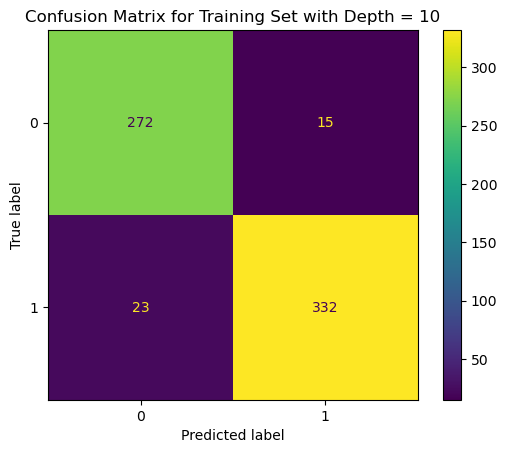

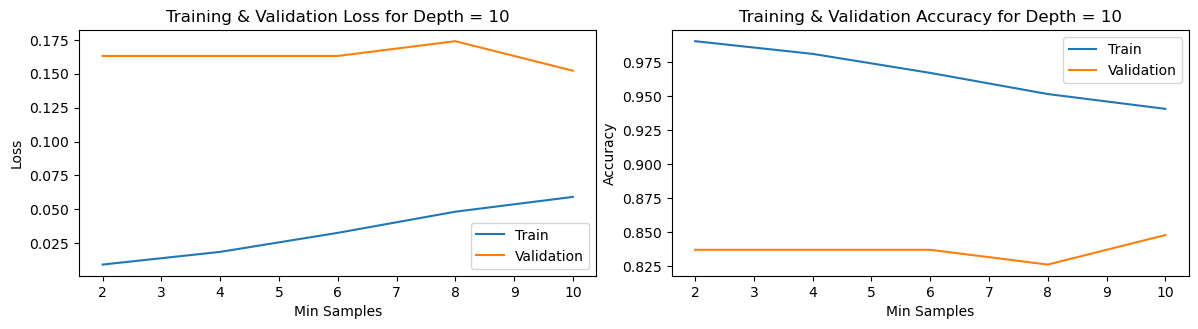

---------------------------------------------------------------------------------------------------------------------------------------------------------------
Depth: 15


--> Min Samples: 2
Training Accuracy: 100.0000%
Training F1 Score: 100.0000%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 4
Training Accuracy: 98.7539%
Training F1 Score: 98.7539%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 6
Training Accuracy: 96.7290%
Training F1 Score: 96.7324%
Validation Accuracy: 83.6957%
Validation F1 Score: 83.7363%


--> Min Samples: 8
Training Accuracy: 95.1713%
Training F1 Score: 95.1764%
Validation Accuracy: 82.6087%
Validation F1 Score: 82.6582%


--> Min Samples: 10
Training Accuracy: 94.0810%
Training F1 Score: 94.0880%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


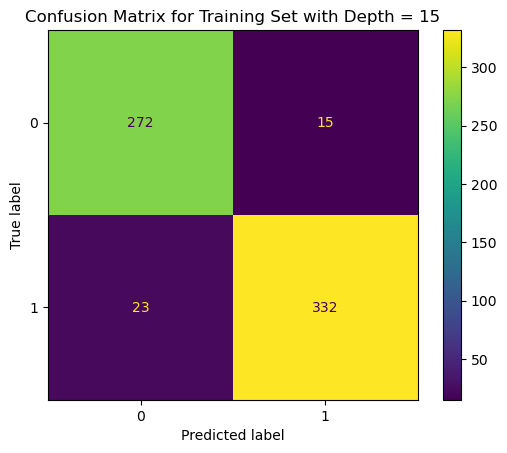

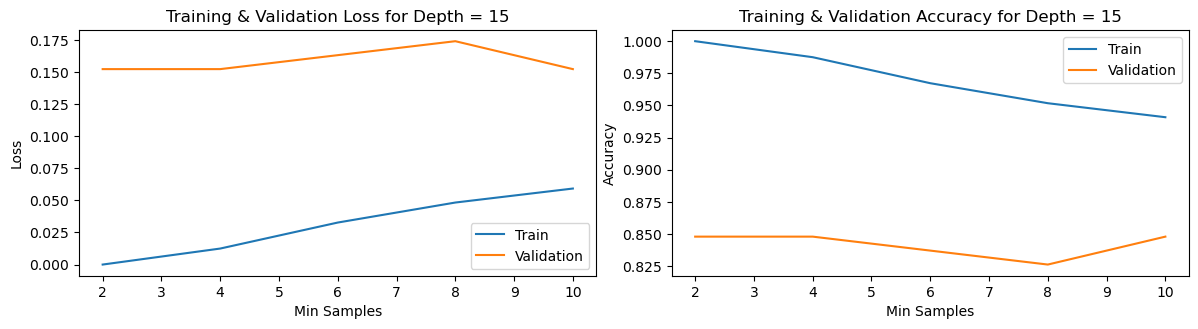

---------------------------------------------------------------------------------------------------------------------------------------------------------------
Depth: 20


--> Min Samples: 2
Training Accuracy: 100.0000%
Training F1 Score: 100.0000%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 4
Training Accuracy: 98.7539%
Training F1 Score: 98.7539%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 6
Training Accuracy: 96.7290%
Training F1 Score: 96.7324%
Validation Accuracy: 83.6957%
Validation F1 Score: 83.7363%


--> Min Samples: 8
Training Accuracy: 95.1713%
Training F1 Score: 95.1764%
Validation Accuracy: 82.6087%
Validation F1 Score: 82.6582%


--> Min Samples: 10
Training Accuracy: 94.0810%
Training F1 Score: 94.0880%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


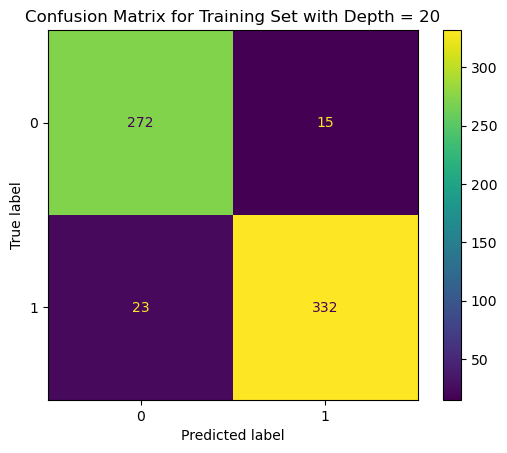

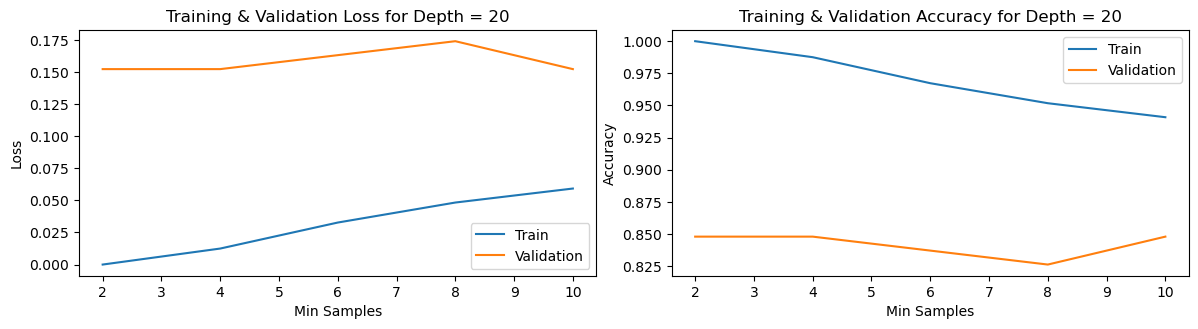

---------------------------------------------------------------------------------------------------------------------------------------------------------------
Depth: 25


--> Min Samples: 2
Training Accuracy: 100.0000%
Training F1 Score: 100.0000%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 4
Training Accuracy: 98.7539%
Training F1 Score: 98.7539%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 6
Training Accuracy: 96.7290%
Training F1 Score: 96.7324%
Validation Accuracy: 83.6957%
Validation F1 Score: 83.7363%


--> Min Samples: 8
Training Accuracy: 95.1713%
Training F1 Score: 95.1764%
Validation Accuracy: 82.6087%
Validation F1 Score: 82.6582%


--> Min Samples: 10
Training Accuracy: 94.0810%
Training F1 Score: 94.0880%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


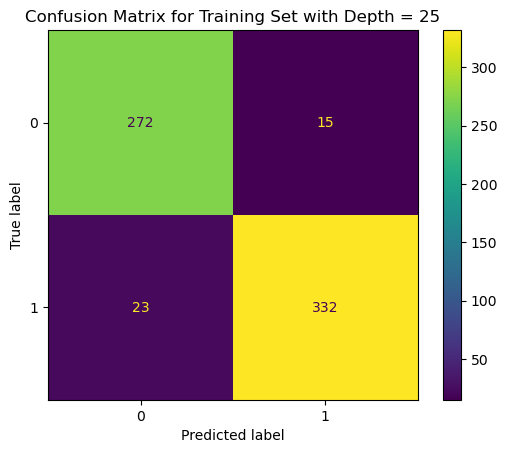

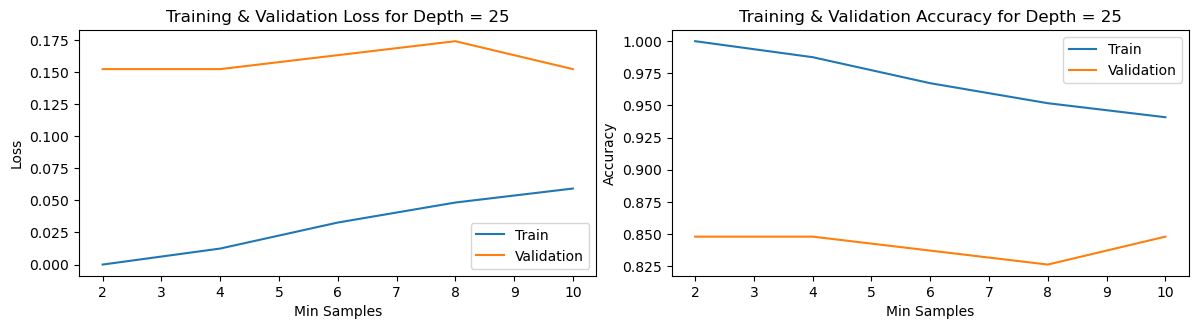

---------------------------------------------------------------------------------------------------------------------------------------------------------------
Depth: 30


--> Min Samples: 2
Training Accuracy: 100.0000%
Training F1 Score: 100.0000%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 4
Training Accuracy: 98.7539%
Training F1 Score: 98.7539%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 6
Training Accuracy: 96.7290%
Training F1 Score: 96.7324%
Validation Accuracy: 83.6957%
Validation F1 Score: 83.7363%


--> Min Samples: 8
Training Accuracy: 95.1713%
Training F1 Score: 95.1764%
Validation Accuracy: 82.6087%
Validation F1 Score: 82.6582%


--> Min Samples: 10
Training Accuracy: 94.0810%
Training F1 Score: 94.0880%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


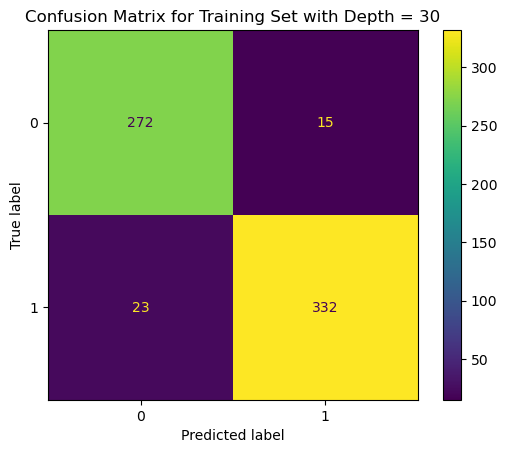

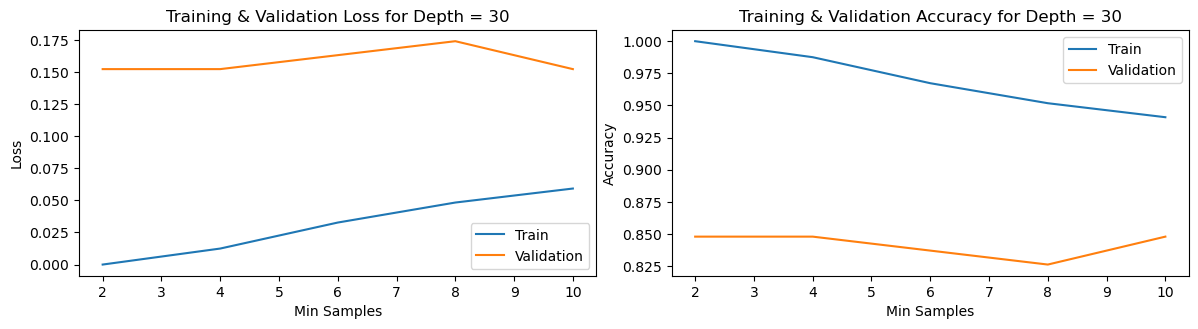

---------------------------------------------------------------------------------------------------------------------------------------------------------------
Depth: 35


--> Min Samples: 2
Training Accuracy: 100.0000%
Training F1 Score: 100.0000%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 4
Training Accuracy: 98.7539%
Training F1 Score: 98.7539%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 6
Training Accuracy: 96.7290%
Training F1 Score: 96.7324%
Validation Accuracy: 83.6957%
Validation F1 Score: 83.7363%


--> Min Samples: 8
Training Accuracy: 95.1713%
Training F1 Score: 95.1764%
Validation Accuracy: 82.6087%
Validation F1 Score: 82.6582%


--> Min Samples: 10
Training Accuracy: 94.0810%
Training F1 Score: 94.0880%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


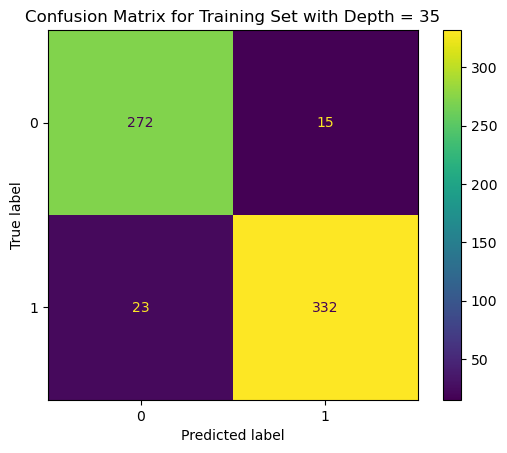

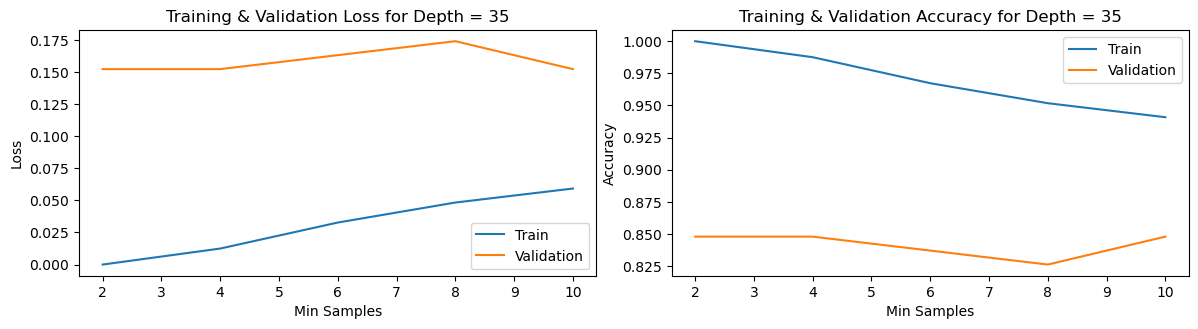

---------------------------------------------------------------------------------------------------------------------------------------------------------------
Depth: 40


--> Min Samples: 2
Training Accuracy: 100.0000%
Training F1 Score: 100.0000%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 4
Training Accuracy: 98.7539%
Training F1 Score: 98.7539%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 6
Training Accuracy: 96.7290%
Training F1 Score: 96.7324%
Validation Accuracy: 83.6957%
Validation F1 Score: 83.7363%


--> Min Samples: 8
Training Accuracy: 95.1713%
Training F1 Score: 95.1764%
Validation Accuracy: 82.6087%
Validation F1 Score: 82.6582%


--> Min Samples: 10
Training Accuracy: 94.0810%
Training F1 Score: 94.0880%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


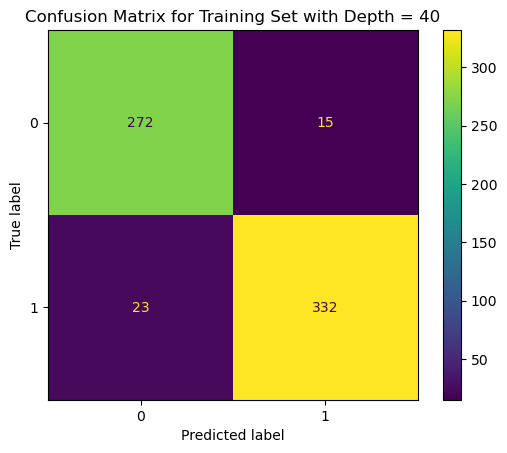

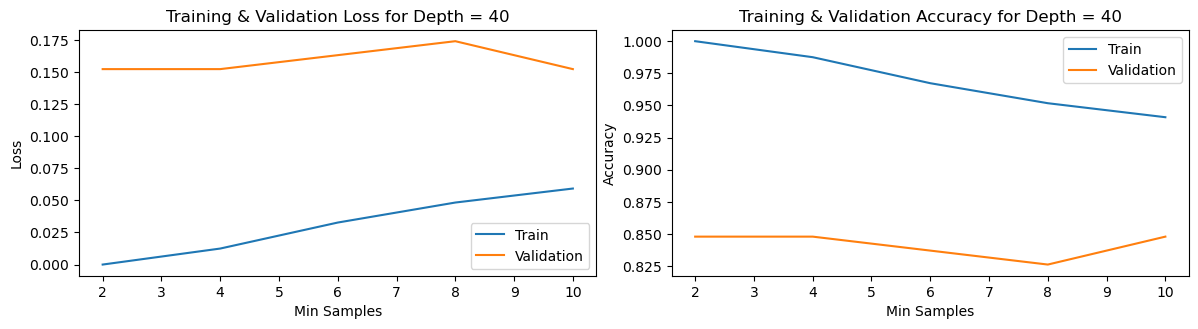

---------------------------------------------------------------------------------------------------------------------------------------------------------------
Depth: 45


--> Min Samples: 2
Training Accuracy: 100.0000%
Training F1 Score: 100.0000%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 4
Training Accuracy: 98.7539%
Training F1 Score: 98.7539%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 6
Training Accuracy: 96.7290%
Training F1 Score: 96.7324%
Validation Accuracy: 83.6957%
Validation F1 Score: 83.7363%


--> Min Samples: 8
Training Accuracy: 95.1713%
Training F1 Score: 95.1764%
Validation Accuracy: 82.6087%
Validation F1 Score: 82.6582%


--> Min Samples: 10
Training Accuracy: 94.0810%
Training F1 Score: 94.0880%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


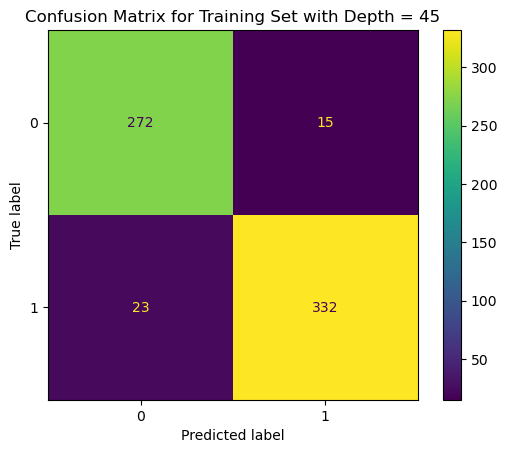

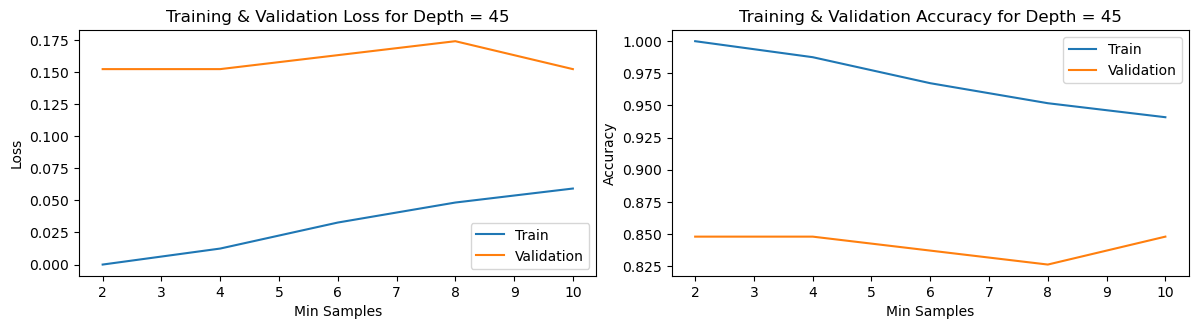

---------------------------------------------------------------------------------------------------------------------------------------------------------------
Depth: 50


--> Min Samples: 2
Training Accuracy: 100.0000%
Training F1 Score: 100.0000%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 4
Training Accuracy: 98.7539%
Training F1 Score: 98.7539%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 6
Training Accuracy: 96.7290%
Training F1 Score: 96.7324%
Validation Accuracy: 83.6957%
Validation F1 Score: 83.7363%


--> Min Samples: 8
Training Accuracy: 95.1713%
Training F1 Score: 95.1764%
Validation Accuracy: 82.6087%
Validation F1 Score: 82.6582%


--> Min Samples: 10
Training Accuracy: 94.0810%
Training F1 Score: 94.0880%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


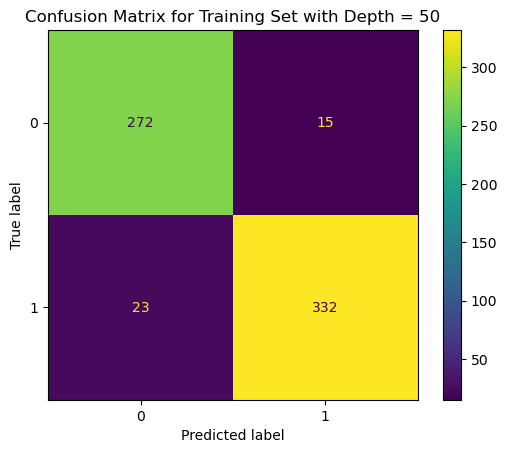

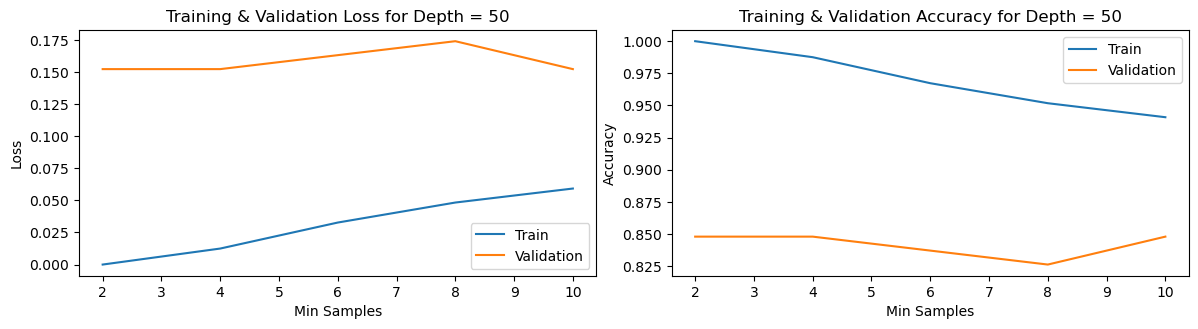

---------------------------------------------------------------------------------------------------------------------------------------------------------------
Depth: 55


--> Min Samples: 2
Training Accuracy: 100.0000%
Training F1 Score: 100.0000%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 4
Training Accuracy: 98.7539%
Training F1 Score: 98.7539%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 6
Training Accuracy: 96.7290%
Training F1 Score: 96.7324%
Validation Accuracy: 83.6957%
Validation F1 Score: 83.7363%


--> Min Samples: 8
Training Accuracy: 95.1713%
Training F1 Score: 95.1764%
Validation Accuracy: 82.6087%
Validation F1 Score: 82.6582%


--> Min Samples: 10
Training Accuracy: 94.0810%
Training F1 Score: 94.0880%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


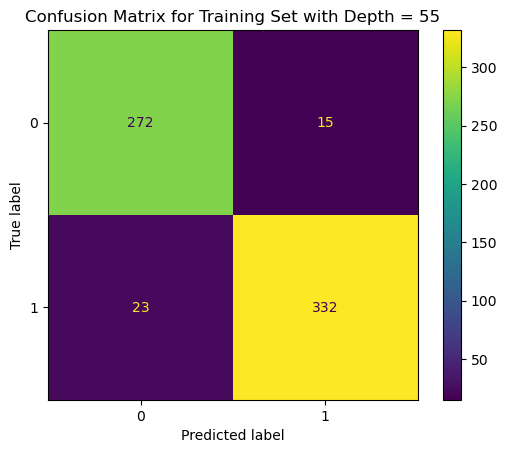

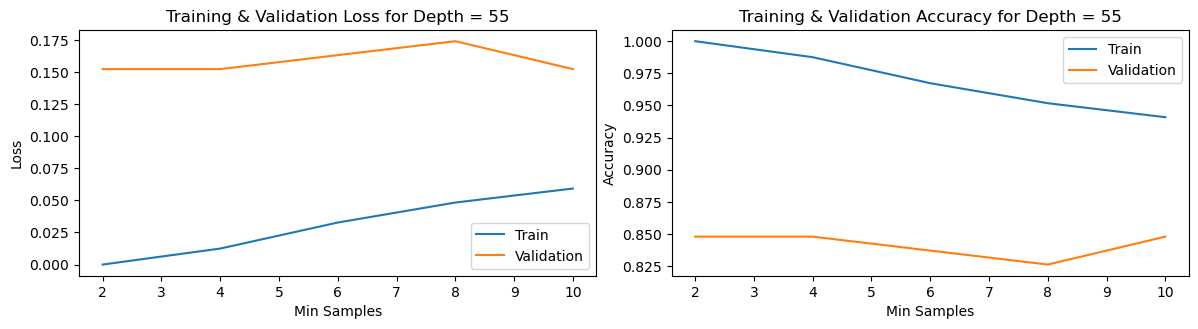

---------------------------------------------------------------------------------------------------------------------------------------------------------------
Depth: 60


--> Min Samples: 2
Training Accuracy: 100.0000%
Training F1 Score: 100.0000%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 4
Training Accuracy: 98.7539%
Training F1 Score: 98.7539%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 6
Training Accuracy: 96.7290%
Training F1 Score: 96.7324%
Validation Accuracy: 83.6957%
Validation F1 Score: 83.7363%


--> Min Samples: 8
Training Accuracy: 95.1713%
Training F1 Score: 95.1764%
Validation Accuracy: 82.6087%
Validation F1 Score: 82.6582%


--> Min Samples: 10
Training Accuracy: 94.0810%
Training F1 Score: 94.0880%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


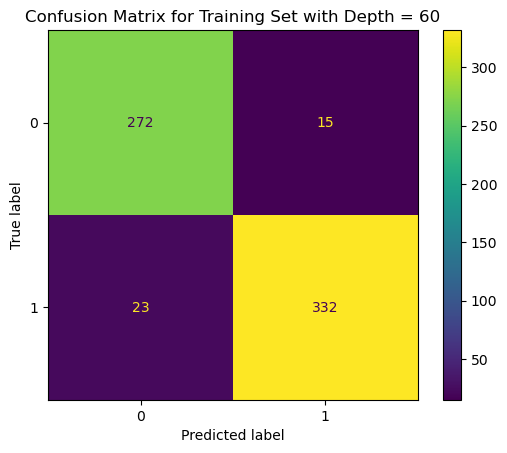

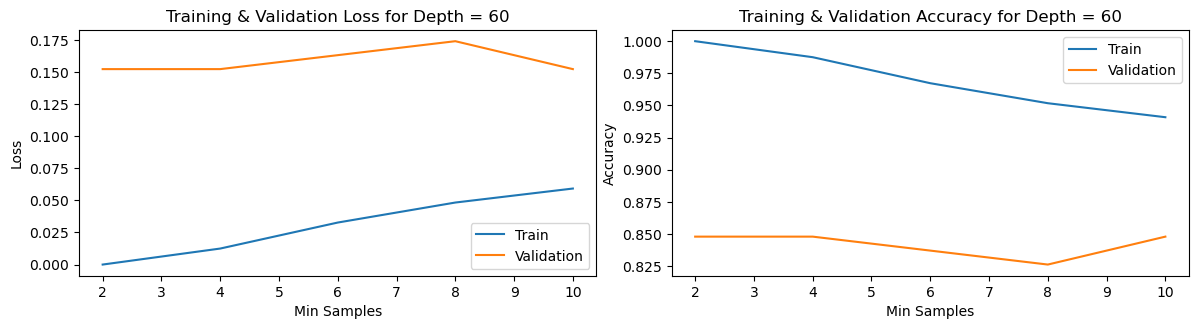

---------------------------------------------------------------------------------------------------------------------------------------------------------------
Depth: 65


--> Min Samples: 2
Training Accuracy: 100.0000%
Training F1 Score: 100.0000%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 4
Training Accuracy: 98.7539%
Training F1 Score: 98.7539%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 6
Training Accuracy: 96.7290%
Training F1 Score: 96.7324%
Validation Accuracy: 83.6957%
Validation F1 Score: 83.7363%


--> Min Samples: 8
Training Accuracy: 95.1713%
Training F1 Score: 95.1764%
Validation Accuracy: 82.6087%
Validation F1 Score: 82.6582%


--> Min Samples: 10
Training Accuracy: 94.0810%
Training F1 Score: 94.0880%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


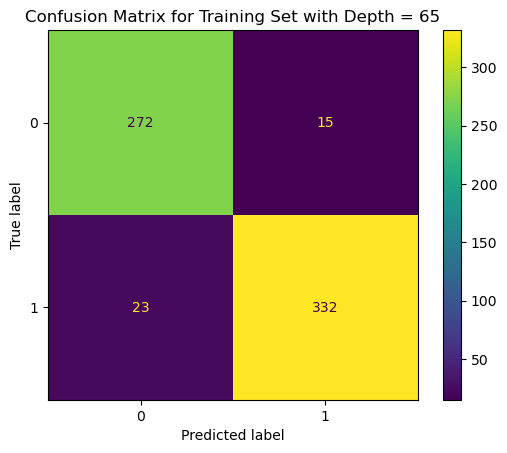

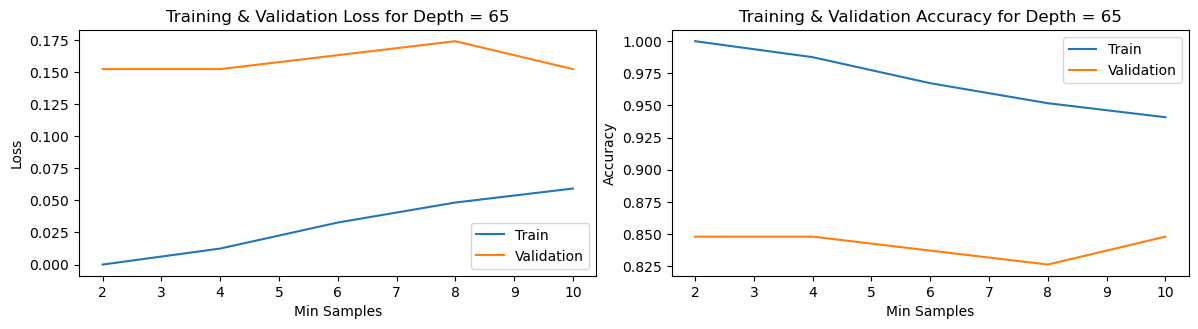

---------------------------------------------------------------------------------------------------------------------------------------------------------------
Depth: 70


--> Min Samples: 2
Training Accuracy: 100.0000%
Training F1 Score: 100.0000%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 4
Training Accuracy: 98.7539%
Training F1 Score: 98.7539%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 6
Training Accuracy: 96.7290%
Training F1 Score: 96.7324%
Validation Accuracy: 83.6957%
Validation F1 Score: 83.7363%


--> Min Samples: 8
Training Accuracy: 95.1713%
Training F1 Score: 95.1764%
Validation Accuracy: 82.6087%
Validation F1 Score: 82.6582%


--> Min Samples: 10
Training Accuracy: 94.0810%
Training F1 Score: 94.0880%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


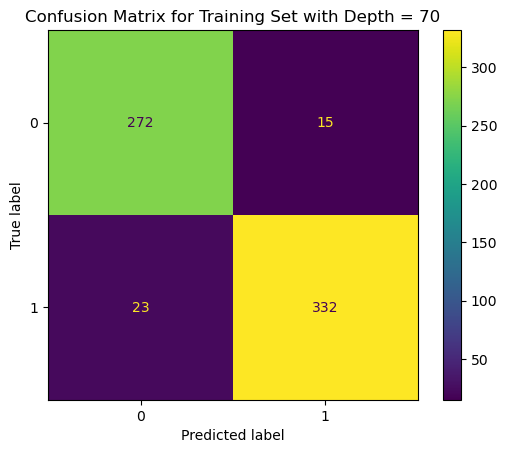

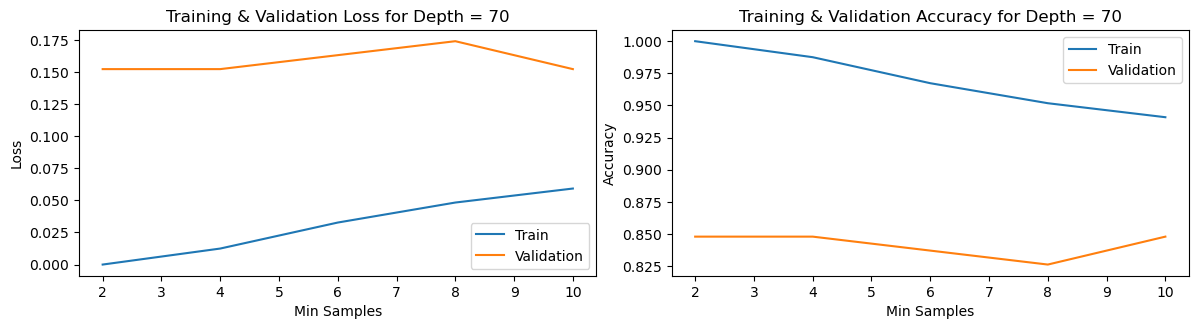

---------------------------------------------------------------------------------------------------------------------------------------------------------------
Depth: 75


--> Min Samples: 2
Training Accuracy: 100.0000%
Training F1 Score: 100.0000%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 4
Training Accuracy: 98.7539%
Training F1 Score: 98.7539%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 6
Training Accuracy: 96.7290%
Training F1 Score: 96.7324%
Validation Accuracy: 83.6957%
Validation F1 Score: 83.7363%


--> Min Samples: 8
Training Accuracy: 95.1713%
Training F1 Score: 95.1764%
Validation Accuracy: 82.6087%
Validation F1 Score: 82.6582%


--> Min Samples: 10
Training Accuracy: 94.0810%
Training F1 Score: 94.0880%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


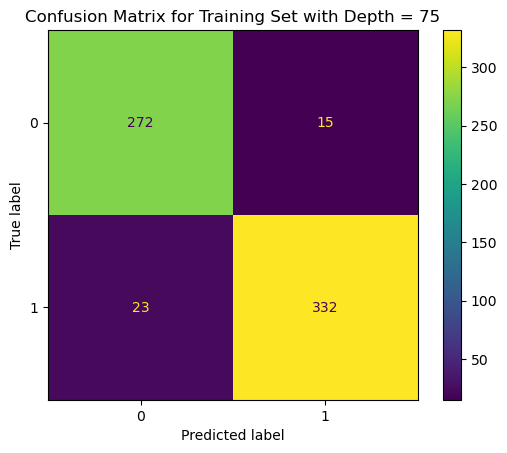

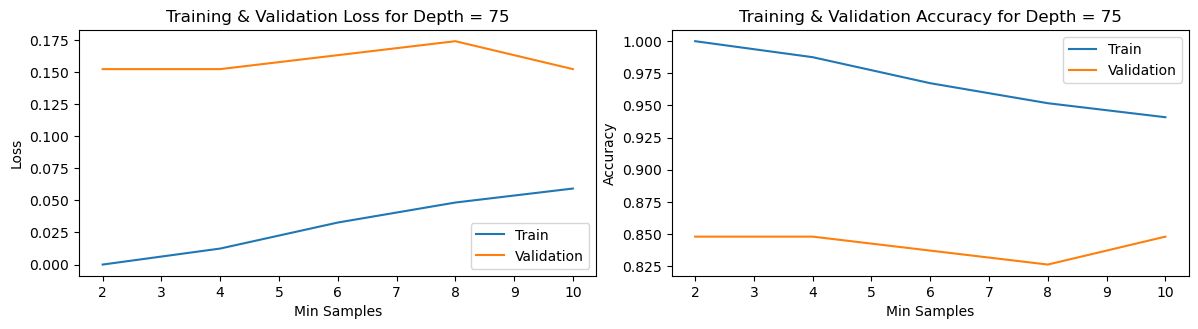

---------------------------------------------------------------------------------------------------------------------------------------------------------------
Depth: 80


--> Min Samples: 2
Training Accuracy: 100.0000%
Training F1 Score: 100.0000%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 4
Training Accuracy: 98.7539%
Training F1 Score: 98.7539%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 6
Training Accuracy: 96.7290%
Training F1 Score: 96.7324%
Validation Accuracy: 83.6957%
Validation F1 Score: 83.7363%


--> Min Samples: 8
Training Accuracy: 95.1713%
Training F1 Score: 95.1764%
Validation Accuracy: 82.6087%
Validation F1 Score: 82.6582%


--> Min Samples: 10
Training Accuracy: 94.0810%
Training F1 Score: 94.0880%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


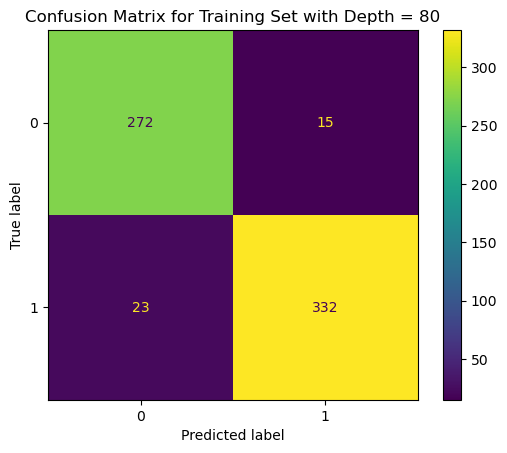

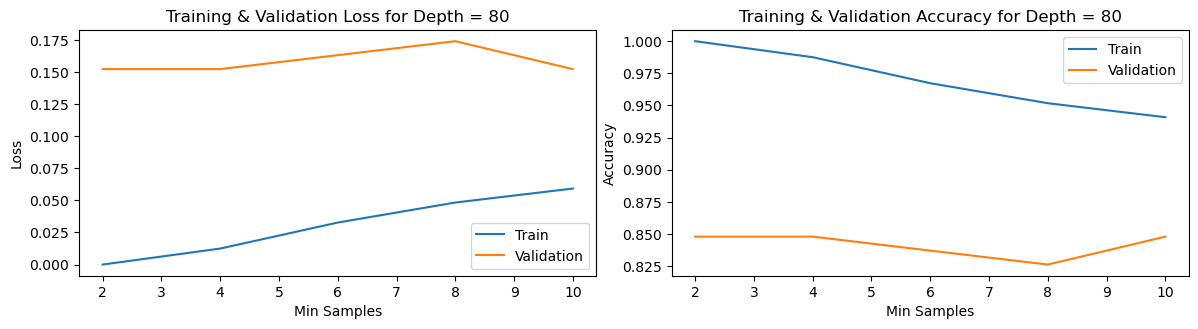

---------------------------------------------------------------------------------------------------------------------------------------------------------------
Depth: 85


--> Min Samples: 2
Training Accuracy: 100.0000%
Training F1 Score: 100.0000%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 4
Training Accuracy: 98.7539%
Training F1 Score: 98.7539%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 6
Training Accuracy: 96.7290%
Training F1 Score: 96.7324%
Validation Accuracy: 83.6957%
Validation F1 Score: 83.7363%


--> Min Samples: 8
Training Accuracy: 95.1713%
Training F1 Score: 95.1764%
Validation Accuracy: 82.6087%
Validation F1 Score: 82.6582%


--> Min Samples: 10
Training Accuracy: 94.0810%
Training F1 Score: 94.0880%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


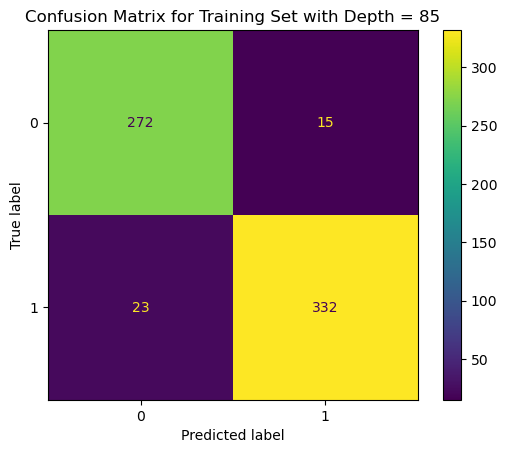

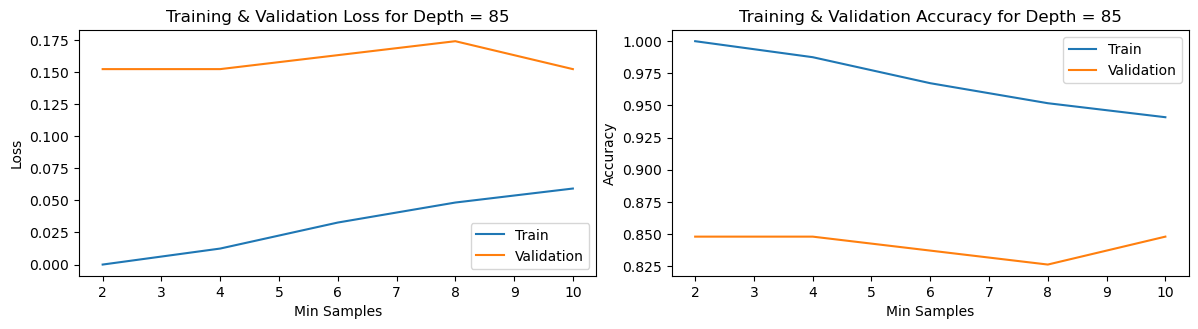

---------------------------------------------------------------------------------------------------------------------------------------------------------------
Depth: 90


--> Min Samples: 2
Training Accuracy: 100.0000%
Training F1 Score: 100.0000%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 4
Training Accuracy: 98.7539%
Training F1 Score: 98.7539%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 6
Training Accuracy: 96.7290%
Training F1 Score: 96.7324%
Validation Accuracy: 83.6957%
Validation F1 Score: 83.7363%


--> Min Samples: 8
Training Accuracy: 95.1713%
Training F1 Score: 95.1764%
Validation Accuracy: 82.6087%
Validation F1 Score: 82.6582%


--> Min Samples: 10
Training Accuracy: 94.0810%
Training F1 Score: 94.0880%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


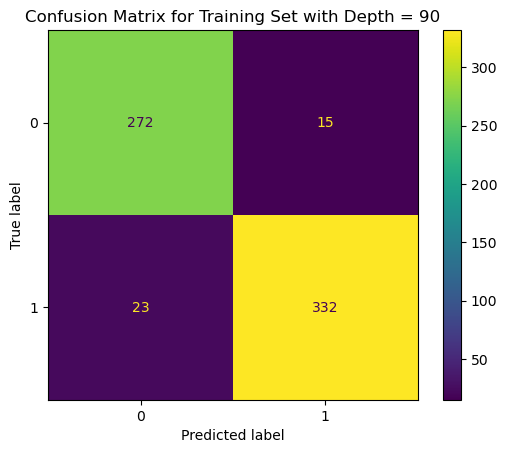

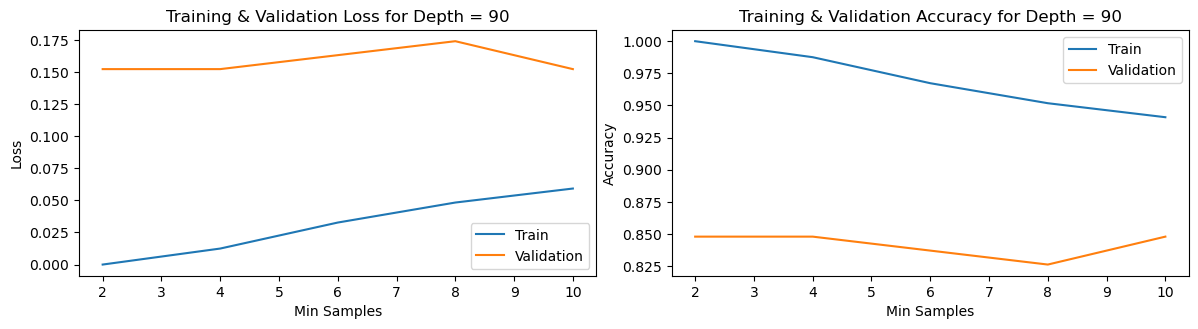

---------------------------------------------------------------------------------------------------------------------------------------------------------------
Depth: 95


--> Min Samples: 2
Training Accuracy: 100.0000%
Training F1 Score: 100.0000%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 4
Training Accuracy: 98.7539%
Training F1 Score: 98.7539%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 6
Training Accuracy: 96.7290%
Training F1 Score: 96.7324%
Validation Accuracy: 83.6957%
Validation F1 Score: 83.7363%


--> Min Samples: 8
Training Accuracy: 95.1713%
Training F1 Score: 95.1764%
Validation Accuracy: 82.6087%
Validation F1 Score: 82.6582%


--> Min Samples: 10
Training Accuracy: 94.0810%
Training F1 Score: 94.0880%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


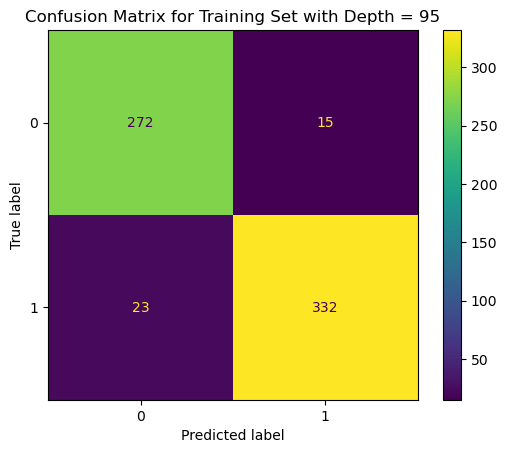

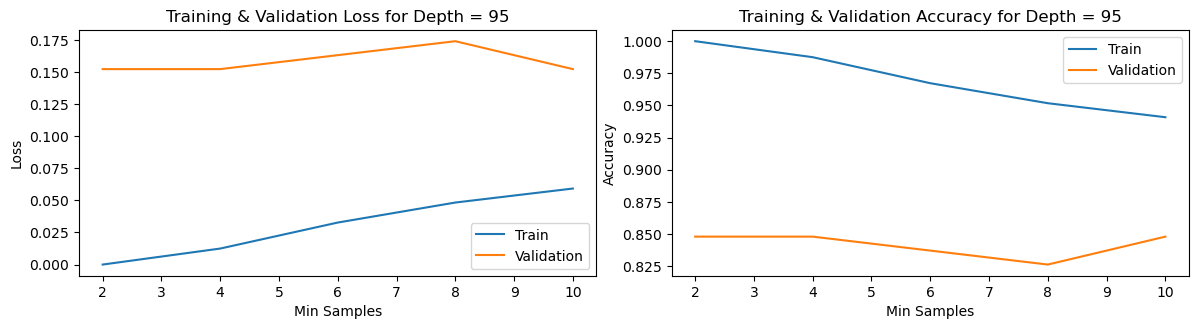

---------------------------------------------------------------------------------------------------------------------------------------------------------------
Depth: 100


--> Min Samples: 2
Training Accuracy: 100.0000%
Training F1 Score: 100.0000%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 4
Training Accuracy: 98.7539%
Training F1 Score: 98.7539%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


--> Min Samples: 6
Training Accuracy: 96.7290%
Training F1 Score: 96.7324%
Validation Accuracy: 83.6957%
Validation F1 Score: 83.7363%


--> Min Samples: 8
Training Accuracy: 95.1713%
Training F1 Score: 95.1764%
Validation Accuracy: 82.6087%
Validation F1 Score: 82.6582%


--> Min Samples: 10
Training Accuracy: 94.0810%
Training F1 Score: 94.0880%
Validation Accuracy: 84.7826%
Validation F1 Score: 84.8259%


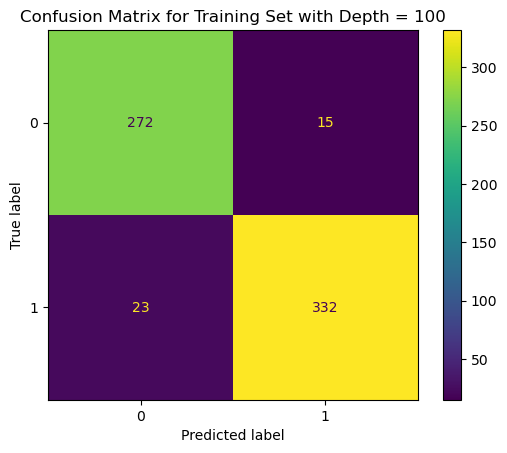

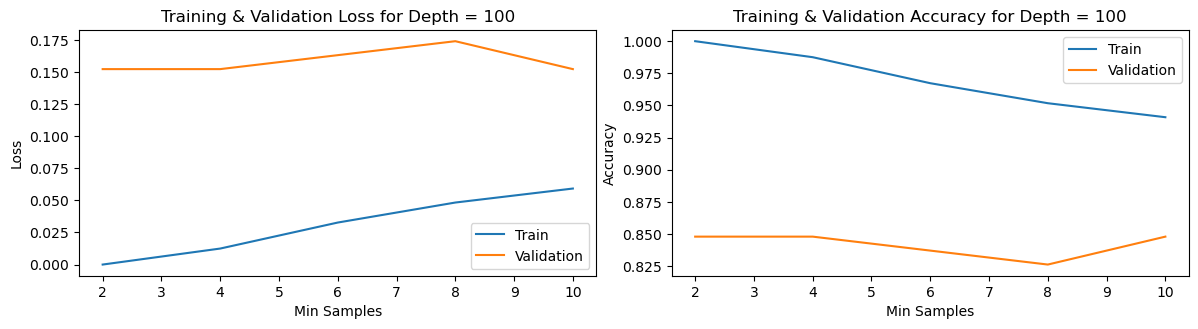

---------------------------------------------------------------------------------------------------------------------------------------------------------------


In [286]:
# Train the decision tree
from sklearn.metrics import ConfusionMatrixDisplay, f1_score


dict_decision_tree = {}
results_decision_tree = {}

for depth in range(10, 105, 5):
    train_loss_decision_tree, val_loss_decision_tree = [], []
    train_accuracy_decision_tree, val_accuracy_decision_tree = [], []
    train_f1_score_decision_tree, val_f1_score_decision_tree = [], []
    
    print(f"Depth: {depth}")
    for min_samples in range(2, 11, 2):
        y_pred_train = None
        y_pred_val = None
        print("\n")
        print(f"--> Min Samples: {min_samples}")
        tree = DecisionTree(max_depth=depth, min_samples_split=min_samples)
        tree.fit(X_train.values, y_train.values)
        # Predict the classes of the test set
        y_pred_train = tree.predict_all(X_train.values)

        from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
        train_accuracy = accuracy_score(y_train, y_pred_train)
        print(f"Training Accuracy: {train_accuracy * 100:.4f}%")
        # print("\nClassification Report:")
        # print(classification_report(y_test, y_pred))
        
        f1_score_train = f1_score(y_train, y_pred_train, average='weighted')
        train_f1_score_decision_tree.append(f1_score_train)
        print(f"Training F1 Score: {f1_score_train * 100:.4f}%")

        train_accuracy_decision_tree.append(train_accuracy)
        train_loss_decision_tree.append(1-train_accuracy)
        y_pred_val = tree.predict_all(X_val.values)
        val_accuracy = accuracy_score(y_val, y_pred_val)
        print(f"Validation Accuracy: {val_accuracy * 100:.4f}%")
        val_accuracy_decision_tree.append(val_accuracy)
        val_loss_decision_tree.append(1-val_accuracy)
        f1_score_val = f1_score(y_val, y_pred_val, average='weighted')
        val_f1_score_decision_tree.append(f1_score_val)
        print(f"Validation F1 Score: {f1_score_val * 100:.4f}%")
     
    dict_decision_tree[depth] = (train_loss_decision_tree, val_loss_decision_tree, train_accuracy_decision_tree, val_accuracy_decision_tree, train_f1_score_decision_tree, val_f1_score_decision_tree)
    results_decision_tree[depth] = {
        "train_loss": train_loss_decision_tree,
        "val_loss": val_loss_decision_tree,
        "train_accuracy": train_accuracy_decision_tree,
        "val_accuracy": val_accuracy_decision_tree,
        "train_f1_score": train_f1_score_decision_tree,
        "val_f1_score": val_f1_score_decision_tree
    }
    # print(results_decision_tree[depth])
    
    cm = confusion_matrix(y_train, y_pred_train)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(2)))
    disp.plot(cmap='viridis', values_format='d')
    plt.title(f"Confusion Matrix for Training Set with Depth = {depth}")
    plt.show()
    
    # plot the training and validation loss & accuracy for the current learning rate
    plt.figure(figsize=(12, 6))
    min_samples = range(2,11,2)
    
    # plot the training and validation loss
    plt.subplot(2, 2, 1)    
    plt.title(f"Training & Validation Loss for Depth = {depth}")
    plt.plot(min_samples, train_loss_decision_tree, label="Train")
    plt.plot(min_samples, val_loss_decision_tree, label="Validation")
    plt.xlabel("Min Samples")
    plt.ylabel("Loss")
    plt.legend()
    
    # plot the training and validation accuracy
    plt.subplot(2, 2, 2)
    plt.title(f"Training & Validation Accuracy for Depth = {depth}")
    plt.plot(min_samples, train_accuracy_decision_tree, label="Train")
    plt.plot(min_samples, val_accuracy_decision_tree, label="Validation")
    plt.xlabel("Min Samples")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    print("---------------------------------------------------------------------------------------------------------------------------------------------------------------")

Best Hyperparameters: Depth = 10, Min Samples Split = 6
Best Validation Accuracy: 84.7826%
Validation F1 Score: 83.7363%


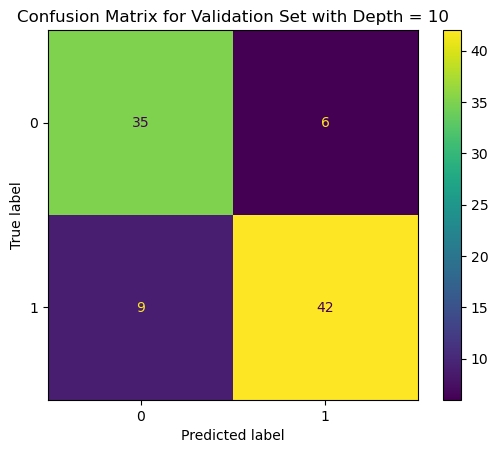

In [287]:
# Find the best hyperparameters



# best_depth = None
# best_min_samples = None
# best_val_accuracy = -1

# for depth in results_decision_tree:
#     for min_samples in range(2,11):
#         val_accuracy = results_decision_tree[depth]["val_accuracy"][min_samples-2]
#         if val_accuracy > best_val_accuracy:
#             best_val_accuracy = val_accuracy
#             best_depth = depth
#             best_min_samples = min_samples
            
# print(f"Best Depth: {best_depth}")
# print(f"Best Min Samples: {best_min_samples}")
# print(f"Best Validation Accuracy: {best_val_accuracy * 100:.4f}%")

# # Train the decision tree with the best hyperparameters
# tree = DecisionTree(max_depth=best_depth, min_samples_split=best_min_samples)
# tree.fit(X_train.values, y_train.values)

# # Predict the classes of the test set
# y_pred_test = tree.predict_all(X_test.values)

# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# test_accuracy = accuracy_score(y_test, y_pred_test)
# print(f"Test Accuracy: {test_accuracy * 100:.4f}%")
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred_test))

# f1_score_test = f1_score(y_test, y_pred_test, average='weighted')
# print(f"Test F1 Score: {f1_score_test * 100:.4f}%")

# cm = confusion_matrix(y_test, y_pred_test)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(2)))
# disp.plot(cmap='viridis', values_format='d')
# plt.title(f"Confusion Matrix for Test Set with Depth = {best_depth}")
# plt.show()





best_depth = None
best_min_samples = None
best_val_accuracy = 0

for depth, metrics in results_decision_tree.items():
    for i, val_acc in enumerate(metrics["val_accuracy"]):
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            best_depth = depth
            best_min_samples = i + 2  # since min_samples starts from 2

print(f"Best Hyperparameters: Depth = {best_depth}, Min Samples Split = {best_min_samples}")
print(f"Best Validation Accuracy: {best_val_accuracy * 100:.4f}%")

# Train the decision tree with the best hyperparameters
tree = DecisionTree(max_depth=best_depth, min_samples_split=best_min_samples)
tree.fit(X_train.values, y_train.values)

# Predict the classes of the validation set
y_val_pred = tree.predict_all(X_val.values)

# Calculate the F1 score for the validation set
f1_score_val = f1_score(y_val, y_val_pred, average='weighted')
print(f"Validation F1 Score: {f1_score_val * 100:.4f}%")

# Display the confusion matrix for the validation set
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(2)))
disp.plot(cmap='viridis', values_format='d')
plt.title(f"Confusion Matrix for Validation Set with Depth = {best_depth}")
plt.show()



Test Accuracy: 82.6087%
Test F1 Score: 82.6274%


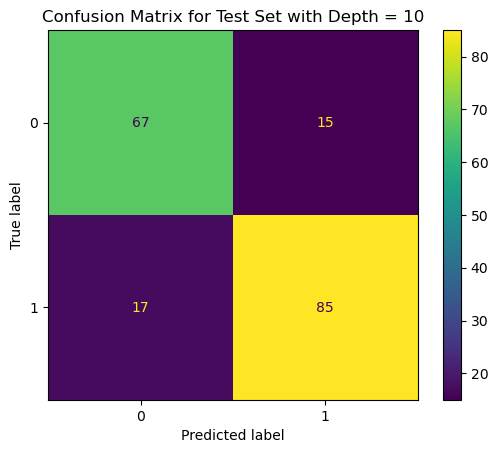

In [288]:
# Train the final model with the best hyperparameters
test_tree = DecisionTree(max_depth=best_depth, min_samples_split=best_min_samples)
test_tree.fit(X_train.values, y_train.values)

# Predict the classes of the test set with the best hyperparameters
y_test_pred = test_tree.predict_all(X_test.values)

# Computr test accuracy and F1 score on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy * 100:.4f}%")
test_f1_score = f1_score(y_test, y_test_pred, average='weighted')
print(f"Test F1 Score: {test_f1_score * 100:.4f}%")

# Display the confusion matrix for the test set
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(2)))
disp.plot(cmap='viridis', values_format='d')
plt.title(f"Confusion Matrix for Test Set with Depth = {best_depth}")
plt.show()


